In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install -q xlrd

In [0]:
df = pd.read_excel (r'/content/drive/My Drive/Data/Smartbox/Analytics_test_Smartbox.xlsx', sep = '')

## Understanding Data

In [6]:
df.head()

,Date,Product Name,Daily Forecast,Daily Sales
0,2017-01-01,Product A,39000,40608.0
1,2017-01-02,Product A,91000,95839.2
2,2017-01-03,Product A,106000,104976.0
3,2017-01-04,Product A,113000,120771.0
4,2017-01-05,Product A,135000,141102.0


Checking for NaN

In [7]:
df.isnull().sum()

Date              0
Product Name      0
Daily Forecast    0
Daily Sales       0
dtype: int64

Renaming the column names by eliminating spaces or specia characters

In [6]:
import re
print("columns", df.columns)


def clean_col(col):
  """Clean a string.

  In our case, the column names of the dataframe. We remove all the characters 
  that are not a digit (0-9) nor a letter (a-z) not capital letter (A-Z) and 
  and replace them by a underscore _
  @params col : string - string to clean
  """
  return re.sub(r"[^0-9a-zA-Z]+", "_", col.rstrip()).lower()


df.columns = [clean_col(col) for col in df.columns]
print("after renaming", df.columns)


columns Index(['date', 'product_name', 'daily_forecast', 'daily_sales'], dtype='object')
after renaming Index(['date', 'product_name', 'daily_forecast', 'daily_sales'], dtype='object')


Checking for uniques product names

In [7]:
df['product_name'].unique()

array(['Product A', 'Product B', 'Product C', 'Product D', 'Product E',
       'Product F', 'Product G'], dtype=object)

Since this dataset deals with date column there is a possibiity to add new columns such as 
"month", "year", "day of a week"

In [0]:
import datetime as dt
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.weekday_name
df['year'] = df['date'].dt.year

In [9]:
df.head()

,date,product_name,daily_forecast,daily_sales,month,day,year
0,2017-01-01,Product A,39000,40608.0,1,Sunday,2017
1,2017-01-02,Product A,91000,95839.2,1,Monday,2017
2,2017-01-03,Product A,106000,104976.0,1,Tuesday,2017
3,2017-01-04,Product A,113000,120771.0,1,Wednesday,2017
4,2017-01-05,Product A,135000,141102.0,1,Thursday,2017


### Checking the "RMSE" of "daily_forecast" and "daily_sales"

In [10]:
from sklearn import metrics
print ("RMSE on the daily sales is :", np.sqrt(metrics.mean_squared_error (df['daily_sales'], df['daily_forecast'])))
print ("MAE on the daily sales is:", metrics.mean_absolute_error (df['daily_sales'], df['daily_forecast']))

RMSE on the daily sales is : 3495681.272966552
MAE on the daily sales is: 147377.86544397642


The prediction and the actual sales price metrics is not so good, so checking the predictions seperately for each product .

##Creating a dataframe for each product

Checking the number of entries for each product

In [11]:
for product in df['product_name'].unique():
  print ( "The number of entries for the {} is {} " . format ( product ,df[df['product_name'] == product].shape[0]))

The number of entries for the Product A is 710 
The number of entries for the Product B is 303 
The number of entries for the Product C is 345 
The number of entries for the Product D is 710 
The number of entries for the Product E is 710 
The number of entries for the Product F is 710 
The number of entries for the Product G is 73 


### Removing the spaces from product names for clear work

In [0]:

pattern = re.compile (r'[^a-zA-Z0-9]+')
#match = pattern.sub ('_', text)
df['product_name'] = df['product_name'].replace (pattern, '_')

###Checking for outliers that is between forecast predictiona nd forecast sales

In [0]:
product_name_products = df.product_name.unique()

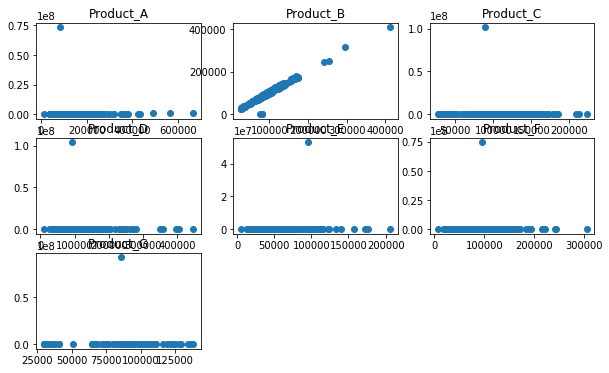

In [14]:
fig = plt.figure (figsize = (10,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, j in enumerate(product_name_products):  
  ax = fig.add_subplot (3,3,i+1)
  ax = plt.scatter (df[df['product_name'] == j]['daily_forecast'], df[df['product_name'] == j]['daily_sales'])
  plt.title (j)
plt.show()

  

###As it can be seen there are outliers in the data which cn be removed in both sales and forecast

In [0]:
def outliers_modified_zscore(col_name):
  #threshold = 3.5
  #print (col_name)
  median_y = np.median (col_name)
  
  median_absolute_deviation_y = np.median([np.abs(y-median_y) for y in col_name])
 # print (median_absolute_deviation_y)
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in col_name]
  #print (modified_z_scores)
  return  pd.Series(np.abs(modified_z_scores))


In [16]:
cols = list(['daily_forecast', 'daily_sales'])

for col in cols:
  col_zscore = col +'_zscore'
  df[col_zscore] = 0
  for j in product_name_products:   
      print (j)
      x = outliers_modified_zscore(df[df['product_name'] == j][col])
      df.loc[min(df.loc[df['product_name'] == j].index.values):max(df.loc[df['product_name'] == j].index.values), col_zscore] = x.values
      

Product_A
Product_B
Product_C
Product_D
Product_E
Product_F
Product_G
Product_A
Product_B
Product_C
Product_D
Product_E
Product_F
Product_G


In [17]:
df.head()

,date,product_name,daily_forecast,daily_sales,month,day,year,daily_forecast_zscore,daily_sales_zscore
0,2017-01-01,Product_A,39000,40608.0,1,Sunday,2017,2.197565,1.864841
1,2017-01-02,Product_A,91000,95839.2,1,Monday,2017,1.066145,0.715437
2,2017-01-03,Product_A,106000,104976.0,1,Tuesday,2017,0.739774,0.525293
3,2017-01-04,Product_A,113000,120771.0,1,Wednesday,2017,0.587468,0.196587
4,2017-01-05,Product_A,135000,141102.0,1,Thursday,2017,0.108790,0.226517


##### Creating a dataframe for each product

#####Now we have a dataframe for each product consisting of all columns and also Zscore

To remove the outliers,  the approach was to select the vaues that has zscore less than 3

This can also be checked locally however, for this application this would do

In [18]:
print ('Before removing outliers' ,df.shape)
df = df[(df['daily_forecast_zscore'] < 3 ) & (df['daily_sales_zscore'] < 3)] 
print ('After removing outliers',  df.shape)

Before removing outliers (3561, 9)
After removing outliers (3439, 9)



### New datasets by removing outliers are created

Plotting the daily forecast against daily sales, to see how well the forecast matches with the sale.

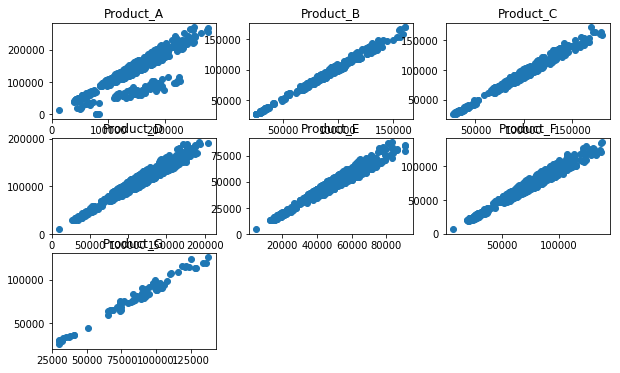

In [19]:
fig = plt.figure (figsize = (10,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, j in enumerate(product_name_products):  
  ax = fig.add_subplot (3,3,i+1)
  ax = plt.scatter (df[df['product_name'] == j]['daily_forecast'], df[df['product_name'] == j]['daily_sales'])
  plt.title (j)
plt.show()


# fig,ax = plt.subplots (figsize = (20,8))
# ax = fig.add_subplot (3,3,1)
# ax = plt.scatter (df_product_A['daily_forecast'], df_product_A['daily_sales'])
# plt.title ('Product A')

# ax = fig.add_subplot (3,3,2)
# ax = plt.scatter (df_product_B['daily_forecast'], df_product_B['daily_sales'])
# plt.title ('Product B')

# ax = fig.add_subplot (3,3,3)
# ax = plt.scatter (df_product_C['daily_forecast'], df_product_C['daily_sales'])
# plt.title ('Product C')

# ax = fig.add_subplot (3,3,4)
# ax = plt.scatter (df_product_D['daily_forecast'], df_product_D['daily_sales'])
# plt.title ('Product D')

# ax = fig.add_subplot (3,3,5)
# ax = plt.scatter (df_product_E['daily_forecast'], df_product_E['daily_sales'])
# plt.title ('Product E')

# ax = fig.add_subplot (3,3,6)
# ax = plt.scatter (df_product_F['daily_forecast'], df_product_F['daily_sales'])
# plt.title ('Product F')

# ax = fig.add_subplot (3,3,7)
# ax = plt.scatter (df_product_G['daily_forecast'], df_product_G['daily_sales'])
# plt.title ('Product G')

# plt.show()

### Calculating "RMSE" and "MAE" for columns "daily_forecast" and "daily_sales" for individual product

In [0]:
metrics_rmse = []
metrics_mae = []
product_names = []
#dataframes = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E, df_product_F, df_product_G]
products = df.product_name.unique()

for i in products:
  metrics_rmse.append (np.sqrt (metrics.mean_squared_error(df[df['product_name'] == i]['daily_sales'], df[df['product_name'] == i]['daily_forecast'])))
  metrics_mae.append (metrics.mean_absolute_error (df[df['product_name'] == i]['daily_sales'], df[df['product_name'] == i]['daily_forecast']))
  product_names.append (df[df['product_name'] == i]['product_name'].unique().max())
  


In [21]:
df_metrics = pd.DataFrame ({'product_name' : product_names,
                           'metrics_rmse' : metrics_rmse, 
                           'metrics_mae' : metrics_mae})

df_metrics

,product_name,metrics_rmse,metrics_mae
0,Product_A,28280.853271,14836.955226
1,Product_B,4921.158771,3704.111034
2,Product_C,8432.657150,6805.940295
3,Product_D,7564.561802,5715.669181
4,Product_E,3352.777606,2523.198062
5,Product_F,4929.999225,3650.317247
6,Product_G,7706.217138,6383.187500


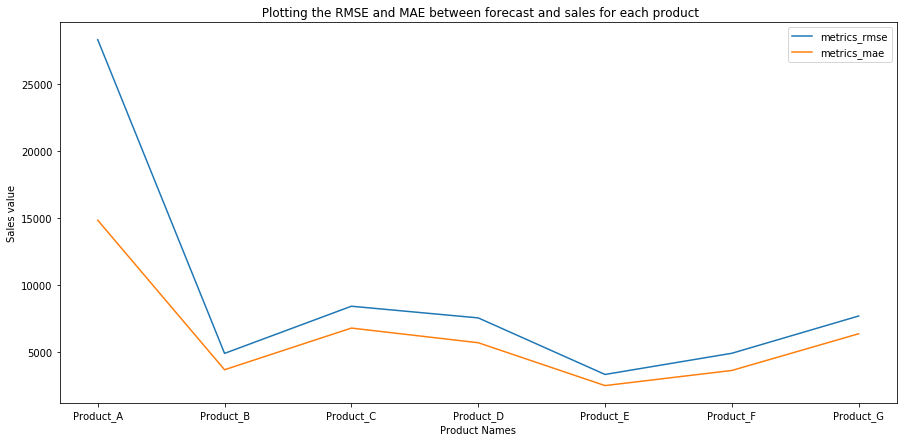

In [22]:
fig, ax = plt.subplots (figsize = (15,7))

ax = plt.plot (df_metrics['product_name'],df_metrics['metrics_rmse'] )
ax = plt.plot (df_metrics['product_name'],df_metrics['metrics_mae'] )
plt.xlabel ('Product Names')
plt.ylabel ('Sales value')
plt.title (' Plotting the RMSE and MAE between forecast and sales for each product')
plt.legend()
plt.show()

### Exporting the concatinated file without outliers into the excel

In [0]:
df.to_csv (r'/content/drive/My Drive/Data/Smartbox/Smartbox_Outliers_Removed.csv')

#Exploratory Data Analysis
#### Mostly sold porduct

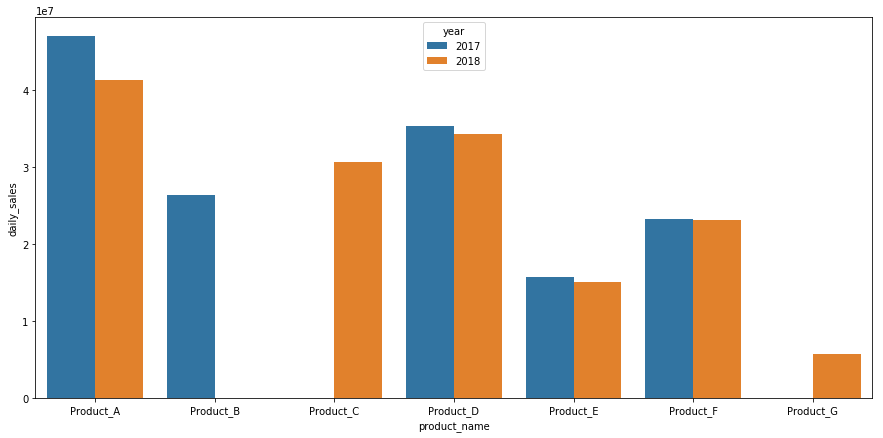

In [24]:
groubby_mostly_sold_year = df.groupby (['product_name', 'year'])['daily_sales'].sum().reset_index()
fig, ax = plt.subplots(figsize=(15,7))

ax = sns.barplot ( x= 'product_name' , y = 'daily_sales' , hue = 'year',  data = groubby_mostly_sold_year, ax = ax )
plt.show()


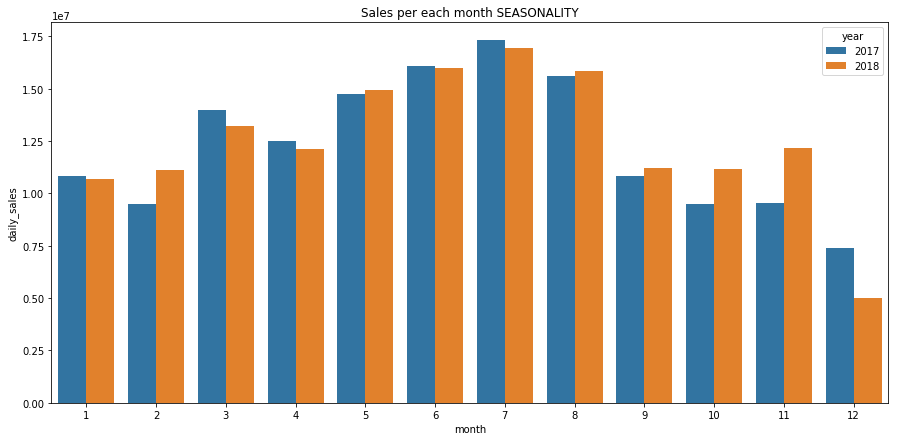

In [25]:
groubby_mostly_sold_month = df.groupby (['year', 'month'])['daily_sales'].sum().reset_index()
fig, ax = plt.subplots(figsize=(15,7))

ax = sns.barplot ( x= 'month' , y = 'daily_sales' , hue = 'year',  data = groubby_mostly_sold_month, ax = ax )
plt.title ('Sales per each month SEASONALITY')
plt.show()

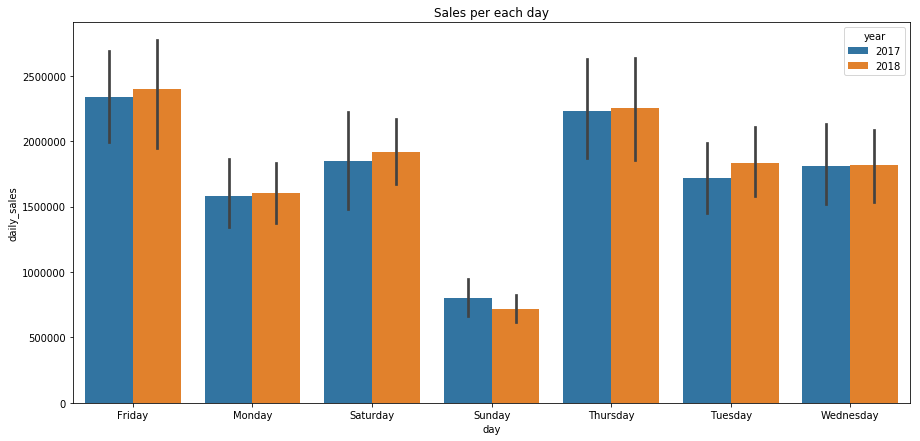

In [26]:
groubby_mostly_sold_day = df.groupby (['year', 'month', 'day'])['daily_sales'].sum().reset_index()
fig, ax = plt.subplots(figsize=(15,7))

ax = sns.barplot ( x= 'day' , y = 'daily_sales' , hue = 'year',  data = groubby_mostly_sold_day, ax = ax )
plt.title ('Sales per each day')
plt.show()

#Applying Model
##### Resampling and rolling window

In [27]:
df_model = df.set_index('date')
df_model.head()

,product_name,daily_forecast,daily_sales,month,day,year,daily_forecast_zscore,daily_sales_zscore
date,,,,,,,,
2017-01-01,Product_A,39000,40608.0,1,Sunday,2017,2.197565,1.864841
2017-01-02,Product_A,91000,95839.2,1,Monday,2017,1.066145,0.715437
2017-01-03,Product_A,106000,104976.0,1,Tuesday,2017,0.739774,0.525293
2017-01-04,Product_A,113000,120771.0,1,Wednesday,2017,0.587468,0.196587
2017-01-05,Product_A,135000,141102.0,1,Thursday,2017,0.108790,0.226517


## Since timeseries is applied for this purpose just the columns which are necessary is chosen

In [0]:
select_product = 'Product_A'
data_model = pd.DataFrame(df_model[df_model['product_name'] == select_product]['daily_sales'])

###Trend Analysis

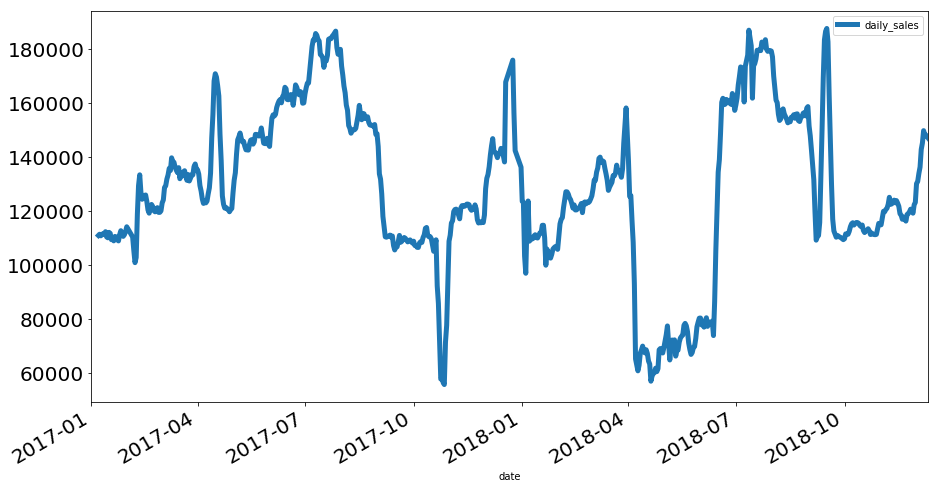

In [29]:
data_model.rolling(7).mean().plot(figsize=(15,8), linewidth=5, fontsize=20)
plt.show()

###Seasonality Analysis

####Using first discrete difference of objects

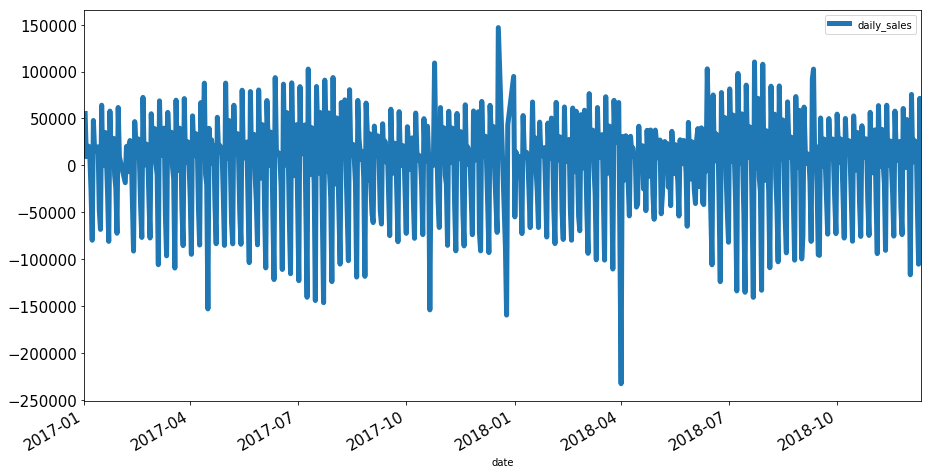

In [30]:
data_model.diff().plot (figsize = (15,8), linewidth = 5, fontsize = 15)
plt.show()

###Periodicity and Autocorrelation

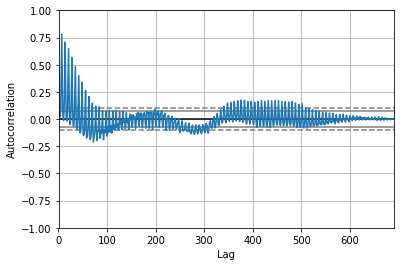

In [31]:
pd.plotting.autocorrelation_plot(data_model)
plt.show()

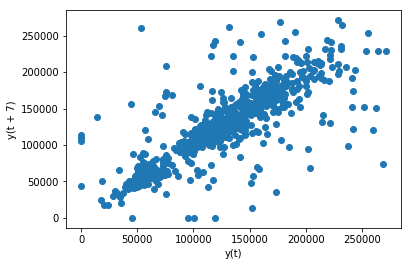

In [32]:
pd.plotting.lag_plot(data_model, lag = 7)
plt.show()

### Another approach for choosing p,d and q 
#Auto ARIMA

In [0]:
!pip install pmdarima

In [42]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(data_model.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=8, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 0, 1); AIC=16707.551, BIC=16725.698, Fit time=0.108 seconds
Fit ARIMA: order=(0, 0, 0); AIC=16936.225, BIC=16945.298, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=16730.600, BIC=16744.210, Fit time=0.023 seconds
Fit ARIMA: order=(0, 0, 1); AIC=16712.494, BIC=16726.104, Fit time=0.026 seconds
Fit ARIMA: order=(2, 0, 1); AIC=16681.170, BIC=16703.854, Fit time=0.211 seconds
Fit ARIMA: order=(2, 0, 0); AIC=16712.701, BIC=16730.847, Fit time=0.023 seconds
Fit ARIMA: order=(2, 0, 2); AIC=16644.797, BIC=16672.017, Fit time=0.305 seconds
Fit ARIMA: order=(3, 0, 3); AIC=16555.867, BIC=16592.160, Fit time=0.563 seconds
Fit ARIMA: order=(2, 0, 3); AIC=16610.028, BIC=16641.785, Fit time=0.491 seconds
Fit ARIMA: order=(4, 0, 3); AIC=16552.247, BIC=16593.078, Fit time=0.787 seconds
Fit ARIMA: order=(4, 0, 2); AIC=16568.173, BIC=16604.466, Fit time=0.541 seconds
Fit ARIMA: order=(3, 0, 2); AIC=16639.715, BIC=16671.472, Fit time=0.379 seconds
Fit ARIMA: order=(5, 0, 3); 

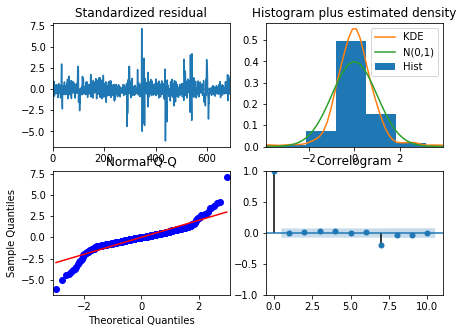

In [43]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [0]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()